In [1]:
from keras.models import Sequential
from keras.layers import ConvLSTM2D, Conv3D, Dense, Flatten, GlobalAveragePooling2D, Conv2D, BatchNormalization, Reshape
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.backend import sum
from keras.layers import ConvLSTM2D, BatchNormalization, Conv3D, AveragePooling3D, Reshape,Dense,AveragePooling2D,GlobalAveragePooling2D, GlobalAveragePooling3D, Conv2D, MaxPooling2D, Flatten, TimeDistributed, Lambda, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import rmsprop, adam
from keras.models import load_model

Using TensorFlow backend.


In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error

C:\Users\bigBro\AppData\Roaming\Python\Python37\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from tqdm import tqdm

In [16]:
from keras import layers
from keras import Input
from keras.models import Model
from keras.utils import plot_model

In [4]:
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
import gc
import tensorflow

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tensorflow.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.Session(config=config))

In [4]:
h5f = h5py.File('D:/total_data_ro.h5','r')

In [5]:
data = h5f['total_2018'][:]
data_gen = h5f['gen_2018'][:]
h5f.close()

In [6]:
data.shape

(8760, 10, 75, 75)

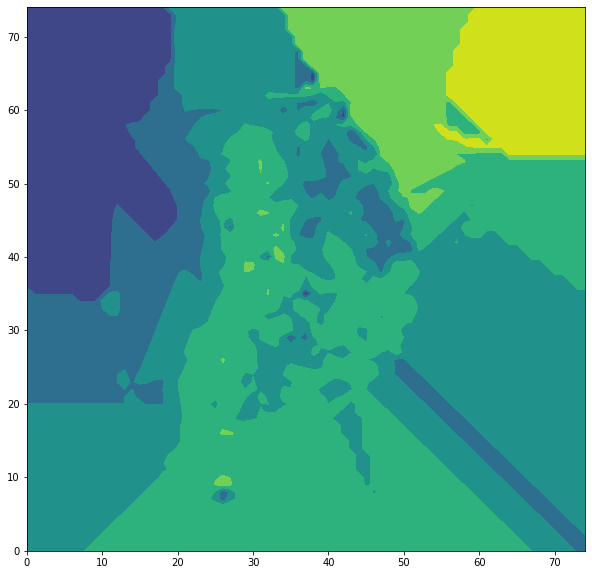

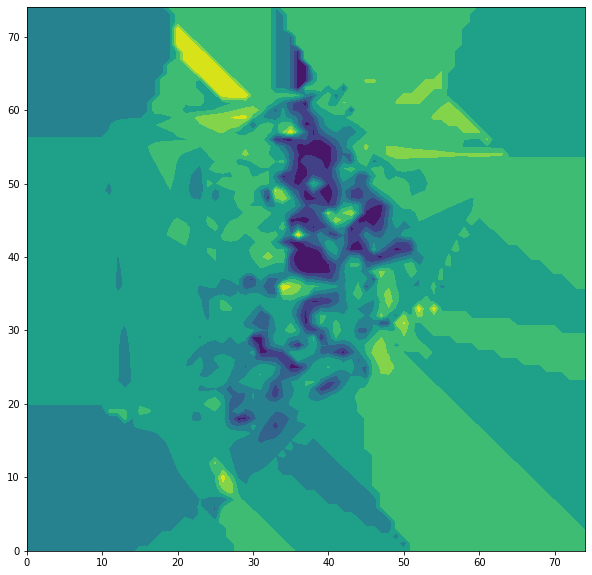

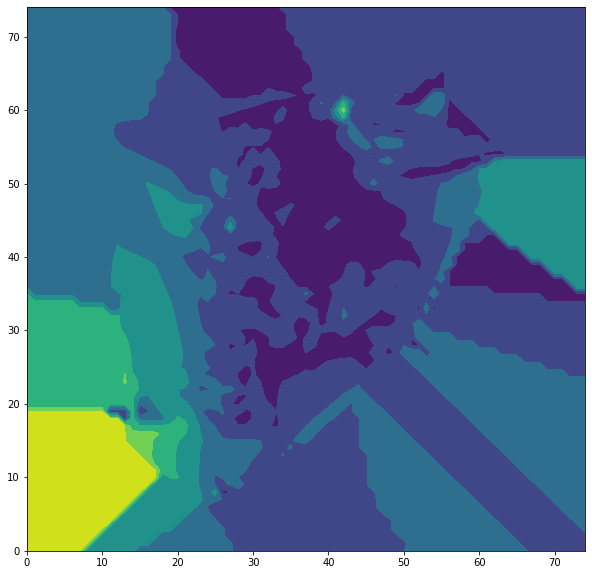

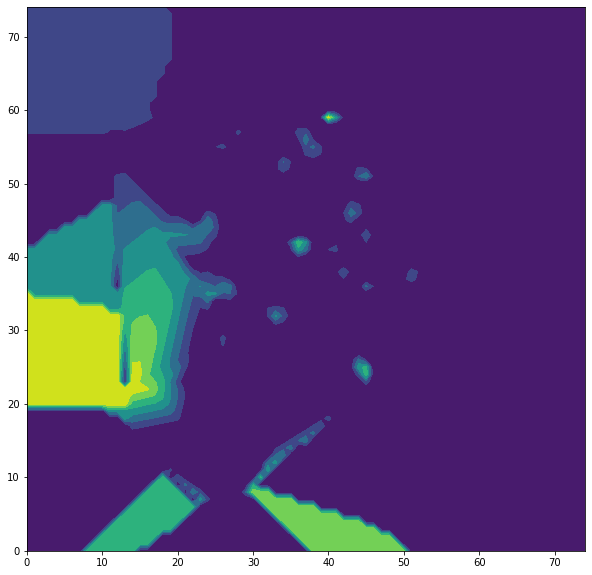

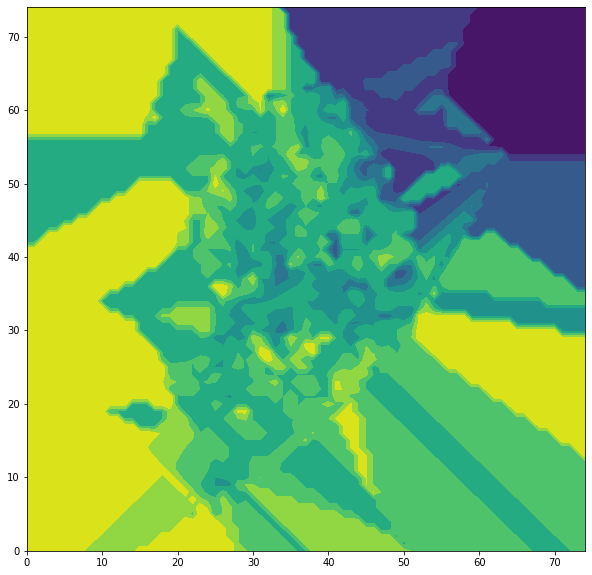

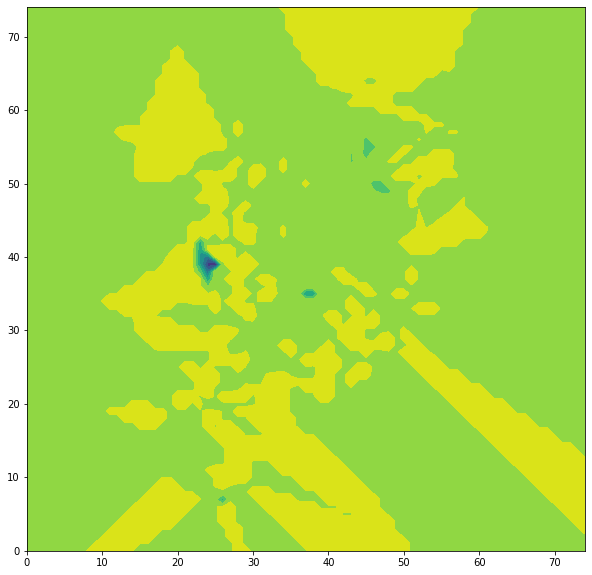

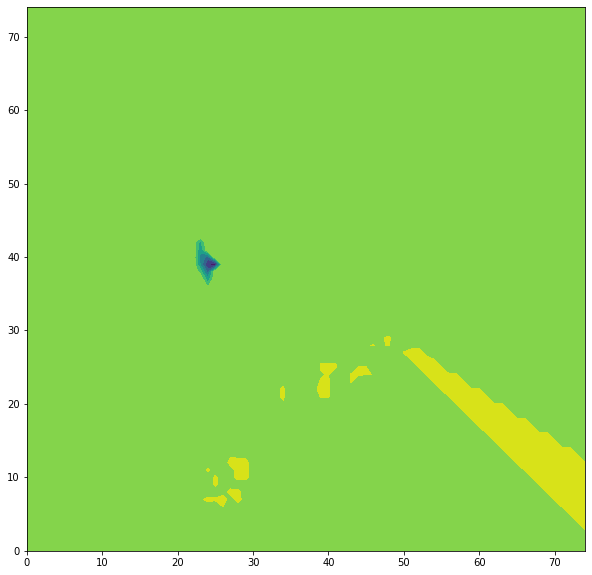

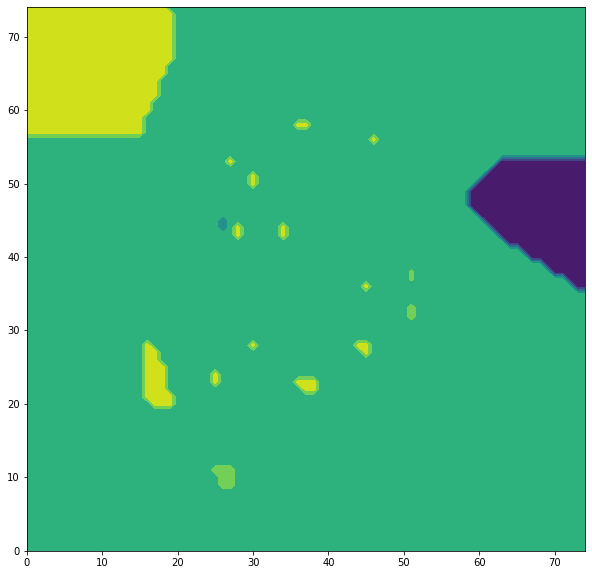

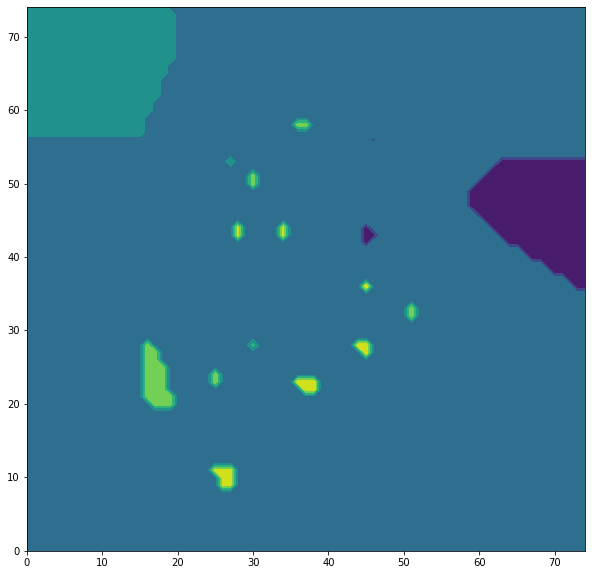

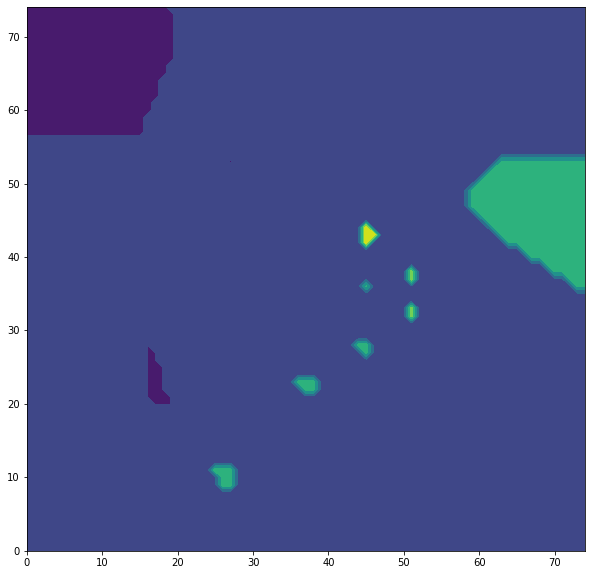

In [26]:
for i in range(10):
    plt.figure(figsize=(10,10))
    cb = plt.contourf(data[3000,i,:,:])
    plt.show(cb)
    #plt.savefig(str(i)+'.pdf')

In [6]:
date_test = pd.date_range(pd.Timestamp('2018-01-01T00'), pd.Timestamp('2018-12-31T23'), freq='H')
len(date_test)

8760

In [11]:
len(data_gen)

8760

In [9]:
def generator(data, target, lookback, delay, min_index, max_index, shuffle=False, batch_size=128):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback))
        #samples = np.zeros((len(rows), lookback, data.shape[-3], data.shape[-2], data.shape[-1]))
        targets = np.zeros((len(rows)))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j])
            samples[j] = data[indices]
            targets[j] = target[rows[j] + delay - 2]
        #yield samples, targets
        return samples, targets

In [14]:
def generator(data, target, lookback, delay, min_index, max_index, shuffle=False, batch_size=128):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback, data.shape[-3], data.shape[-2], data.shape[-1]))
        targets = np.zeros((len(rows)))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j])
            samples[j] = data[indices]
            targets[j] = target[rows[j] + delay - 1]
        #yield samples, targets
        return samples, targets

In [10]:
dates, power = generator(date_test, data_gen, 72, 2, 0, None, shuffle=False, batch_size=20)

In [11]:
dates = pd.DataFrame(dates).apply(pd.to_datetime)

In [12]:
pd.concat([dates, pd.Series(power)], axis=1).iloc[:,-2:]

,71,0
0,2018-01-03 23:00:00,40.72032
1,2018-01-04 00:00:00,41.72208
2,2018-01-04 01:00:00,35.14536
3,2018-01-04 02:00:00,33.28320
4,2018-01-04 03:00:00,35.88456
5,2018-01-04 04:00:00,34.01808
6,2018-01-04 05:00:00,28.30872
7,2018-01-04 06:00:00,34.16688
8,2018-01-04 07:00:00,38.70720
9,2018-01-04 08:00:00,39.28656


In [156]:
model = Sequential()
model.add(ConvLSTM2D(filters=20, kernel_size=(3, 3),
                   input_shape=(None, 75, 75, 10),
                    data_format='channels_last', 
                   padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(filters=1, kernel_size=(1, 1),
                    data_format='channels_last', activation='relu',
                   padding='same'))

model.add(Flatten())

model.add(Dense(units=16, activation='relu'))

model.add(Dense(units=1))

model.compile(optimizer=adam(lr=0.001), loss='mae')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_6 (ConvLSTM2D)  (None, 75, 75, 20)        21680     
_________________________________________________________________
batch_normalization_6 (Batch (None, 75, 75, 20)        80        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 1)         21        
_________________________________________________________________
flatten_5 (Flatten)          (None, 5625)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                90016     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 17        
Total params: 111,814
Trainable params: 111,774
Non-trainable params: 40
_________________________________________________________________


In [184]:
model = Sequential()

model.add(ConvLSTM2D(filters=1, kernel_size=(3, 3),
                   input_shape=(None, 75, 75, 10),
                    data_format='channels_last', return_sequences=True,
                   padding='same', dropout=0.3))
model.add(BatchNormalization())

model.add(ConvLSTM2D(filters=10, kernel_size=(3, 3),
                    data_format='channels_last',
                   padding='same', dropout=0.3))
model.add(BatchNormalization())

model.add(Conv2D(filters=1, kernel_size=(1, 1),
                    data_format='channels_last', activation='relu',
                   padding='same'))

model.add(Flatten())
model.add(Dropout(0.3))

model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1))

model.compile(optimizer=adam(lr=0.001), loss='mae')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_9 (ConvLSTM2D)  (None, None, 75, 75, 1)   400       
_________________________________________________________________
batch_normalization_9 (Batch (None, None, 75, 75, 1)   4         
_________________________________________________________________
conv_lst_m2d_10 (ConvLSTM2D) (None, 75, 75, 10)        4000      
_________________________________________________________________
batch_normalization_10 (Batc (None, 75, 75, 10)        40        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 75, 75, 1)         11        
_________________________________________________________________
flatten_7 (Flatten)          (None, 5625)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5625)              0         
__________

In [13]:
model = Sequential()

model.add(ConvLSTM2D(filters=1, kernel_size=(3, 3),
                   input_shape=(None, 75, 75, 10),
                    data_format='channels_last', return_sequences=True,
                   padding='same'))
model.add(BatchNormalization())

model.add(ConvLSTM2D(filters=10, kernel_size=(3, 3),
                    data_format='channels_last',
                   padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(filters=1, kernel_size=(1, 1),
                    data_format='channels_last', activation='relu',
                   padding='same'))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1))

model.compile(optimizer=adam(lr=0.001), loss='mae')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 75, 75, 1)   400       
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 75, 75, 1)   4         
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 75, 75, 10)        4000      
_________________________________________________________________
batch_normalization_2 (Batch (None, 75, 75, 10)        40        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 1)         11        
_________________________________________________________________
flatten_1 (Flatten)  

In [6]:
sc = RobustScaler()

In [7]:
sc = joblib.load('./data/scaler_gen.pkl')

In [9]:
h5f = h5py.File('D:/total_data_ro.h5','r')
test_data = h5f['total_2019'][:]
test_gen_data = h5f['gen_2019'][:]
h5f.close()

In [15]:
test_gen = generator(test_data, test_gen_data, 72, 0, 200, None, shuffle=False, batch_size=100)

In [16]:
model.load_weights('./data/best_conv1x1 (9).h5')

ValueError: You are trying to load a weight file containing 7 layers into a model with 4 layers.

In [56]:
np.array(test_gen[0]).shape

(100, 72, 10, 75, 75)

In [57]:
test_data = np.array(test_gen[0])

In [58]:
test_data = np.rollaxis(test_data, 2, 5)

In [75]:
test_data.shape

(100, 72, 75, 75, 10)

In [82]:
y_pred = model.predict(test_data)

In [83]:
y_pred.shape

(100, 1)

In [84]:
y_pred = sc.inverse_transform(y_pred)

In [85]:
y_test = test_gen[1]

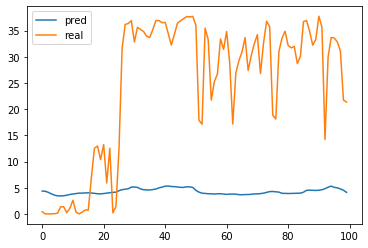

In [86]:
plt.plot(y_pred, label='pred')
plt.plot(y_test, label='real')
plt.legend()
plt.show()

### 19.08.25 Robust with 1 filter ConvLSTM2D, rmsprop=0.001, loss=mae

In [4]:
model = Sequential()

model.add(ConvLSTM2D(filters=1, kernel_size=(3, 3),
                   input_shape=(None, 75, 75, 10),
                    data_format='channels_last',
                   padding='same'))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1))

model.compile(optimizer=rmsprop(lr=0.001), loss='mae')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, 75, 75, 1)         400       
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 1)         4         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5625)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                180032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 180,469
Trainable params: 180,467
Non-trainable params: 2
_________________________________________________________________


In [ ]:
h5f = h5py.File('D:/total_data_ro.h5','r')
train_data = h5f['total_2018'][:]
train_gen_data = h5f['gen_2018'][:]
val_data = h5f['total_2017'][:]
val_gen_data = h5f['gen_2017'][:]
h5f.close()

In [ ]:
train_data = np.rollaxis(train_data, 1, 4)
val_data = np.rollaxis(val_data, 1, 4)

In [7]:
sc = RobustScaler()
sc = joblib.load('./data/scaler_gen.pkl')
h5f = h5py.File('D:/total_data_ro.h5','r')
test_data = h5f['total_2019'][:]
test_gen_data = h5f['gen_2019'][:]
h5f.close()

In [5]:
def generator(data, target, lookback, delay, min_index, max_index, shuffle=False, batch_size=128):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback, data.shape[-3], data.shape[-2], data.shape[-1]))
        targets = np.zeros((len(rows)))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j])
            samples[j] = data[indices]
            targets[j] = target[rows[j] + delay - 1]
        #yield samples, targets
        return samples, targets

In [9]:
len(test_data)

4344

In [10]:
test_gen = generator(test_data, test_gen_data, 72, 0, 800, None, shuffle=False, batch_size=100)

In [11]:
model.load_weights('./data/robust_data_robust_gen.h5')

In [12]:
np.array(test_gen[0]).shape

(100, 72, 10, 75, 75)

In [13]:
X_test = np.array(test_gen[0])

In [14]:
X_test = np.rollaxis(X_test, 2, 5)

In [15]:
X_test.shape

(100, 72, 75, 75, 10)

In [16]:
y_pred = model.predict(X_test)

In [17]:
y_pred.shape

(100, 1)

In [18]:
y_pred = sc.inverse_transform(y_pred)

In [19]:
y_test = test_gen[1]

In [21]:
mean_absolute_error(y_pred, y_test)

4.567425571557671

#### 0~100

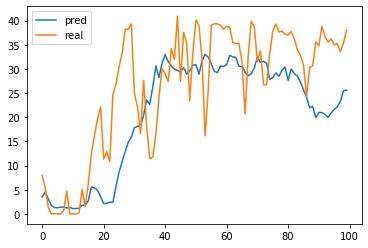

In [23]:
plt.plot(y_pred, label='pred')
plt.plot(y_test, label='real')
plt.legend()
plt.show()

#### 100~200

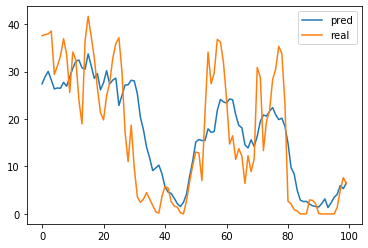

In [35]:
plt.plot(y_pred, label='pred')
plt.plot(y_test, label='real')
plt.legend()
plt.show()

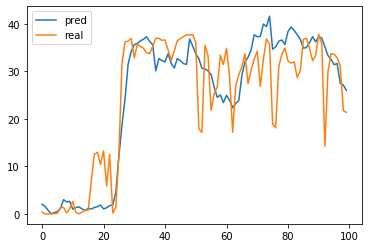

In [51]:
plt.plot(y_pred, label='pred')
plt.plot(y_test, label='real')
plt.legend()
plt.show()

#### 800~900

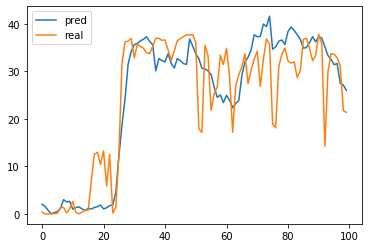

In [21]:
plt.plot(y_pred, label='pred')
plt.plot(y_test, label='real')
plt.legend()
plt.show()

#### robust to Minmax

In [40]:
model.load_weights('./data/robust_data_mm_gen_1.h5')

In [23]:
wind_gen = pd.read_csv('./data/wind_gen.csv')[['발전량']]

In [24]:
sc = MinMaxScaler()

In [25]:
sc.fit(wind_gen)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [32]:
test_gen = generator(test_data, test_gen_data, 72, 0, 800, None, shuffle=False, batch_size=100)
np.array(test_gen[0]).shape

(100, 72, 10, 75, 75)

In [33]:
X_test = np.array(test_gen[0])
X_test = np.rollaxis(X_test, 2, 5)
X_test.shape

(100, 72, 75, 75, 10)

In [41]:
y_pred = model.predict(X_test)

In [42]:
y_pred.shape

(100, 1)

In [43]:
y_pred = sc.inverse_transform(y_pred)

In [44]:
y_test = test_gen[1]

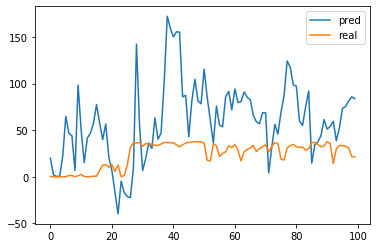

In [45]:
plt.plot(y_pred, label='pred')
plt.plot(y_test, label='real')
plt.legend()
plt.show()

### MinMax model with Robust Output

In [28]:
h5f = h5py.File('D:/total_data_mm.h5','r')
test_data = h5f['total_2019'][:]
test_gen_data = h5f['gen_2019'][:]
h5f.close()

In [29]:
model.load_weights('./data/mm_data_robust_gen_1.h5')

In [30]:
sc = RobustScaler()
sc = joblib.load('./data/scaler_gen.pkl')

In [51]:
graph_data_pred = np.array([])
graph_data_real = np.array([])

In [56]:
for i in tqdm(range(0, 1000, 100)):
    test_gen = generator(test_data, test_gen_data, 72, 0, i, None, shuffle=False, batch_size=100)
    X_test = np.array(test_gen[0])
    X_test = np.rollaxis(X_test, 2, 5)
    y_pred = model.predict(X_test)
    y_pred = sc.inverse_transform(y_pred)
    graph_data_pred = np.append(graph_data_pred, y_pred)
    graph_data_real = np.append(graph_data_real, test_gen[1])


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:39<00:00,  9.94s/it]

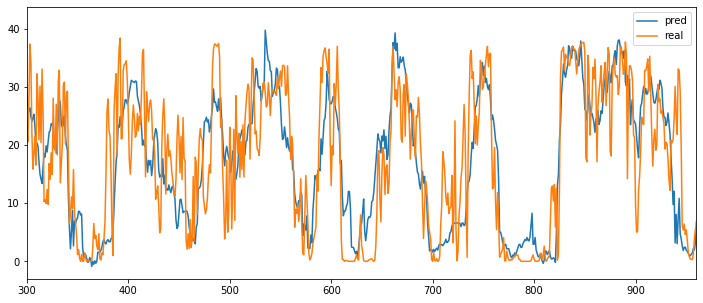

In [60]:
plt.figure(figsize=(12, 5))
plt.xlim(300,960)
plt.plot(graph_data_pred, label='pred')
plt.plot(graph_data_real, label='real')
plt.legend()
plt.show()

In [62]:
mse = mean_squared_error(graph_data_real, graph_data_pred)
mae = mean_absolute_error(graph_data_real, graph_data_pred)

In [63]:
mse, mae

(82.48752205547083, 7.0124376621049755)

In [32]:
test_gen_data.shape

(4344,)

In [31]:
test_gen = generator(test_data, test_gen_data, 72, 0, 800, None, shuffle=False, batch_size=100)
np.array(test_gen[0]).shape

(100, 72, 10, 75, 75)

In [21]:
X_test = np.array(test_gen[0])
X_test = np.rollaxis(X_test, 2, 5)
X_test.shape

(100, 72, 75, 75, 10)

In [22]:
y_pred = model.predict(X_test)

In [23]:
y_pred.shape

(100, 1)

In [39]:
np.append(np.array((10,20)), np.array((10,20)))

array([10, 20, 10, 20])

In [24]:
y_pred = sc.inverse_transform(y_pred)

In [25]:
y_test = test_gen[1]

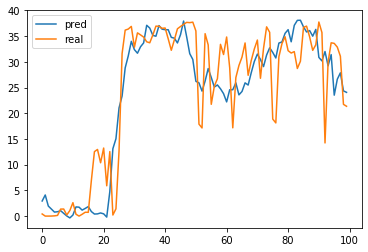

In [26]:
plt.plot(y_pred, label='pred')
plt.plot(y_test, label='real')
plt.legend()
plt.show()

In [27]:
mean_absolute_error(y_pred, y_test)

4.469833972727436

In [73]:
sc.inverse_transform([[0.50]])

array([[13.81194]])

In [77]:
#reset_keras()
model = Sequential()

model.add(ConvLSTM2D(filters=10, kernel_size=(3, 3),
                   input_shape=(None, 75, 75, 10),
                    data_format='channels_last', return_sequences=True,
                   padding='same'))
model.add(BatchNormalization())

model.add(ConvLSTM2D(filters=1, kernel_size=(3, 3),
                   input_shape=(None, 75, 75, 10),
                    data_format='channels_last',
                   padding='same'))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1))

model.compile(optimizer=rmsprop(lr=0.0001), loss='mae')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_4 (ConvLSTM2D)  (None, None, 75, 75, 10)  7240      
_________________________________________________________________
batch_normalization_4 (Batch (None, None, 75, 75, 10)  40        
_________________________________________________________________
conv_lst_m2d_5 (ConvLSTM2D)  (None, 75, 75, 1)         400       
_________________________________________________________________
batch_normalization_5 (Batch (None, 75, 75, 1)         4         
_________________________________________________________________
flatten_3 (Flatten)          (None, 5625)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                180032    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total para

In [94]:
model.load_weights('./data/gen_pred_120h_71h (1).h5')

In [80]:
def generator(data, target, lookback, delay, min_index, max_index, shuffle=False, batch_size=128):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback, data.shape[-3], data.shape[-2], data.shape[-1]))
        targets = np.zeros((len(rows)))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j])
            samples[j] = data[indices]
            targets[j] = target[rows[j] + delay - 1]
        #yield samples, targets
        return samples, targets

In [89]:
test_gen = generator(test_data, test_gen_data, 120, 71, 600, None, shuffle=True, batch_size=30)

In [95]:
X_test = np.array(test_gen[0])
X_test = np.rollaxis(X_test, 2, 5)
X_test.shape

(30, 120, 75, 75, 10)

In [96]:
y_pred = model.predict(X_test)

In [97]:
y_pred = sc.inverse_transform(y_pred)

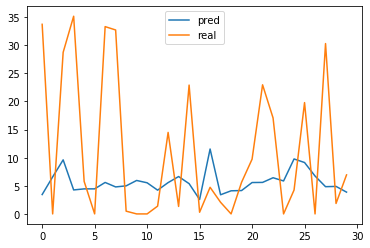

In [98]:
plt.plot(y_pred, label='pred')
plt.plot(test_gen[1], label='real')
plt.legend()
plt.show()

In [99]:
model = Sequential()

model.add(ConvLSTM2D(filters=1, kernel_size=(3, 3),
                   input_shape=(None, 75, 75, 10),
                    data_format='channels_last',
                   padding='same'))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1))

model.compile(optimizer=rmsprop(lr=0.001), loss='mae')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_6 (ConvLSTM2D)  (None, 75, 75, 1)         400       
_________________________________________________________________
batch_normalization_6 (Batch (None, 75, 75, 1)         4         
_________________________________________________________________
flatten_4 (Flatten)          (None, 5625)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                180032    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 180,469
Trainable params: 180,467
Non-trainable params: 2
_________________________________________________________________


In [107]:
model.load_weights('./data/gen_pred_120h_23h_2.h5')

In [101]:
def generator(data, target, lookback, delay, min_index, max_index, shuffle=False, batch_size=128):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback, data.shape[-3], data.shape[-2], data.shape[-1]))
        targets = np.zeros((len(rows)))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j])
            samples[j] = data[indices]
            targets[j] = target[rows[j] + delay - 1]
        #yield samples, targets
        return samples, targets

In [113]:
test_gen = generator(test_data, test_gen_data, 120, 23, 600, None, shuffle=True, batch_size=50)

In [114]:
X_test = np.array(test_gen[0])
X_test = np.rollaxis(X_test, 2, 5)
X_test.shape

(50, 120, 75, 75, 10)

In [115]:
y_pred = model.predict(X_test)

In [116]:
y_pred = sc.inverse_transform(y_pred)

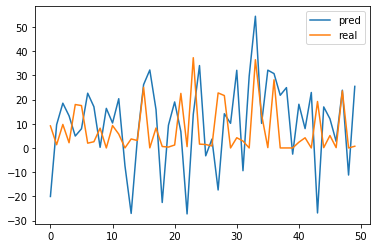

In [119]:
plt.plot(y_pred, label='pred')
plt.plot(test_gen[1], label='real')
plt.legend()
plt.show()

In [189]:
model.load_weights('./data/gen_pred_120h_23h_3.h5')

In [190]:
test_gen = generator(test_data, test_gen_data, 120, 23, 400, None, shuffle=True, batch_size=50)

In [191]:
X_test = np.array(test_gen[0])
X_test = np.rollaxis(X_test, 2, 5)
X_test.shape

(50, 120, 75, 75, 10)

In [192]:
y_pred = model.predict(X_test)

In [193]:
y_pred = sc.inverse_transform(y_pred)

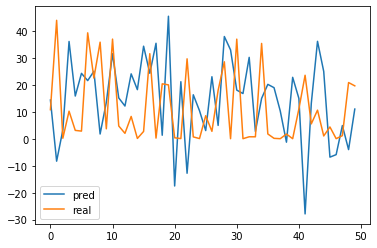

In [194]:
plt.plot(y_pred, label='pred')
plt.plot(test_gen[1], label='real')
plt.legend()
plt.show()

In [245]:
sc.inverse_transform([[0.32]])

array([[10.7470512]])

In [160]:
model.load_weights('./data/gen_pred_120h_47h_1.h5')

In [161]:
test_gen = generator(test_data, test_gen_data, 120, 47, 600, None, shuffle=False, batch_size=50)

In [162]:
X_test = np.array(test_gen[0])
X_test = np.rollaxis(X_test, 2, 5)
X_test.shape

(50, 120, 75, 75, 10)

In [163]:
y_pred = model.predict(X_test)

In [164]:
y_pred = sc.inverse_transform(y_pred)

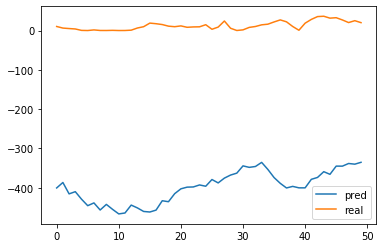

In [165]:
plt.plot(y_pred, label='pred')
plt.plot(test_gen[1], label='real')
plt.legend()
plt.show()

#### 72시간 예측

In [5]:
h5f = h5py.File('D:/total_data_ro.h5','r')
test_data = h5f['total_2019'][:]
test_data_gen = h5f['gen_2019'][:]
h5f.close()

In [7]:
test_data.shape

(4344, 10, 75, 75)

In [8]:
test_data = np.rollaxis(test_data, 1, 4)
test_data.shape

(4344, 75, 75, 10)

In [10]:
sc = RobustScaler()
sc = joblib.load('./data/scaler_gen.pkl')
test_data_gen = sc.transform(test_data_gen.reshape(1, -1))
test_data_gen = test_data_gen.reshape(-1, 1)

In [13]:
def generator(data, target, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=1):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback // step, data.shape[-3], data.shape[-2], data.shape[-1]))
        targets = np.zeros((len(rows), delay))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = target[rows[j] - 1: rows[j] + delay - 1][:,0]
        #yield samples, targets
        return samples, [targets[:,0], targets[:,1], targets[:,2], targets[:,3], targets[:,4], targets[:,5], targets[:,6], targets[:,7], targets[:,8], targets[:,9], targets[:,10], targets[:,11], targets[:,12], targets[:,13], targets[:,14], targets[:,15], targets[:,16], targets[:,17], targets[:,18], targets[:,19], targets[:,20], targets[:,21], targets[:,22], targets[:,23], targets[:,24], targets[:,25], targets[:,26], targets[:,27], targets[:,28], targets[:,29], targets[:,30], targets[:,31], targets[:,32], targets[:,33], targets[:,34], targets[:,35], targets[:,36], targets[:,37], targets[:,38], targets[:,39], targets[:,40], targets[:,41], targets[:,42], targets[:,43], targets[:,44], targets[:,45], targets[:,46], targets[:,47], targets[:,48], targets[:,49], targets[:,50], targets[:,51], targets[:,52], targets[:,53], targets[:,54], targets[:,55], targets[:,56], targets[:,57], targets[:,58], targets[:,59], targets[:,60], targets[:,61], targets[:,62], targets[:,63], targets[:,64], targets[:,65], targets[:,66], targets[:,67], targets[:,68], targets[:,69], targets[:,70], targets[:,71]]

In [17]:
img_input = Input(shape=(None, 75, 75, 10), name='images')
convlstm2d = layers.ConvLSTM2D(filters=20, kernel_size=(3, 3),
                   input_shape=(None, 75, 75, 10),
                    data_format='channels_last', return_sequences=True,
                   padding='same')(img_input)
batch_norm = layers.BatchNormalization()(convlstm2d)

convlstm2d_1x1 = layers.ConvLSTM2D(filters=1, kernel_size=(3, 3),
                    data_format='channels_last',padding='same')(batch_norm)
batch_norm = layers.BatchNormalization()(convlstm2d_1x1)

flatten = layers.Flatten()(batch_norm)

Dense_1_list = [layers.Dense(units=1)(flatten) for i in range(72)]

model = Model(img_input, Dense_1_list)

model.compile(optimizer=rmsprop(lr=0.001), loss=['mae' for i in range(72)])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             (None, None, 75, 75, 0                                            
__________________________________________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)     (None, None, 75, 75, 21680       images[0][0]                     
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, 75, 75, 80          conv_lst_m2d_1[0][0]             
__________________________________________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)     (None, 75, 75, 1)    760         batch_normalization_1[0][0]      
_____________________________________

In [18]:
model.load_weights('./data/gen_pred_72hours.h5')

In [227]:
test_gen = generator(test_data, test_data_gen, 120, 72, 200, None, shuffle=False, batch_size=1)

In [228]:
test_gen[0].shape, len(test_gen[1])

((1, 120, 75, 75, 10), 72)

In [229]:
y_pred = model.predict(test_gen[0])

In [230]:
np.array(y_pred).shape

(72, 1, 1)

In [231]:
np.array(y_pred).reshape(-1,1).shape

(72, 1)

In [232]:
y_pred = sc.inverse_transform(np.array(y_pred).reshape(-1,1))

In [233]:
y_test = sc.inverse_transform(test_gen[1])

In [234]:
y_pred.shape

(72, 1)

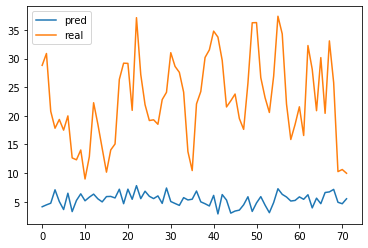

In [235]:
plt.plot(y_pred, label='pred')
plt.plot(y_test, label='real')
plt.legend()
plt.show()

In [75]:
import pickle

In [246]:
with open('./data/result.txt', 'rb') as f:
    data_a = pickle.load(f)

In [247]:
vloss = pd.DataFrame(data_a)

In [248]:
vloss.shape

(100, 147)

In [293]:
sc_mae = vloss.iloc[95,1:-74].values

In [257]:
sc_mae = vloss.iloc[99,74:-1].values

In [294]:
mae = sc.inverse_transform(sc_mae.reshape(-1,1))

In [295]:
mae = mae.reshape(1,-1)

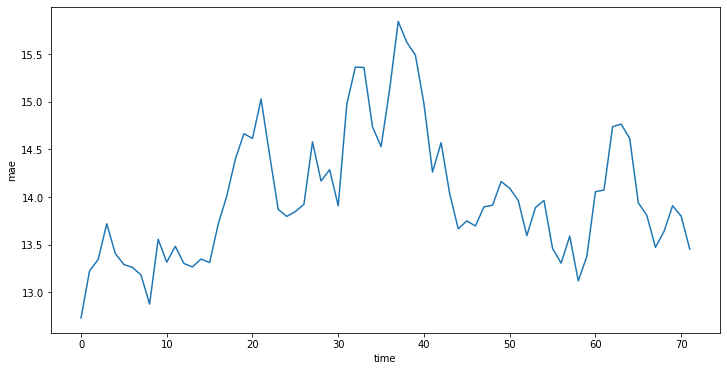

In [296]:
plt.figure(figsize=(12, 6))
plt.ylabel('mae')
plt.xlabel('time')
plt.plot(mae[0])

In [298]:
mae.mean()

14.006050118582262